In [ ]:
# take two weeks, 1 with worms, 1 without
# run model for each picture to count worms
# output images with contours and make sure it is counting the worms correctly
# compare the two weeks
# take in sensor data like temperature, humidity, soil humidity, etc
# check if there is a correlation between the sensor data and the number of worms
# run the above for multiple weeks

In [49]:
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import roboflow
import pandas as pd
import supervision as sv
from inference import get_model
from PIL.ImageFile import ImageFile
import cv2

In [4]:
model = get_model("wigglebin/2")

In [47]:
def analyze_image(image):
    results = model.infer(image)[0]
    return results

def draw_boxes(results, image_path, output_image_path):
    image = Image.open(image_path)
    image_np = np.array(image)  # Convert PIL image to NumPy array
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR

    # Convert the inference results to Supervisely format
    detections = sv.Detections.from_inference(results)

    # Create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()  # Set the color for bounding boxes
    label_annotator = sv.LabelAnnotator()  # Set the color for labels

    labels = [
        f"{model.class_names[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    # Annotate the image with our inference results
    annotated_image_rgb = bounding_box_annotator.annotate(scene=image_bgr, detections=detections)
    annotated_image_bgr = label_annotator.annotate(scene=annotated_image_rgb, detections=detections, labels=labels)

        # Convert the annotated image back to RGB format
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    annotated_image_pil = Image.fromarray(annotated_image_rgb)  # Convert NumPy array back to PIL image

    # Save the annotated image using PIL
    annotated_image_pil.save(output_image_path)

In [45]:
import numpy as np

# Define the folder containing the images

# account for that this week was used for the model training (take daily or hourly images) 
# and the comparison week should also be one of the weeks used for the model training
image_folder = 'downloads/weekly/2024-36' 

all_results = []

# Loop over each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    
    # Open the image
    with Image.open(image_path) as img:
        # Analyze the image
        results = analyze_image(img)
        # detections = sv.Detections.from_inference(results)

        num_items_detected = len(results.predictions)

        # Append the image name and number of worms detected to the list
        all_results.append((image_name, results))


In [51]:
# show bounding boxes on the image
for (image_name, results) in all_results:
    image_path = os.path.join(image_folder, image_name)
    draw_boxes(results, image_path, f"predictions/output/{image_name}")

In [60]:
data = []

# Loop over each image and its detection results
for (image_name, results) in all_results:
    worms_detected = [pred for pred in results.predictions if pred.class_name == 'worm']
    num_worms = len(worms_detected)
    
    # Extract date and time from image_name
    date_str = image_name.split('.')[0]
    date_time = pd.to_datetime(date_str, format='%Y-%m-%d-%H-%M')
    
    # Extract week number
    week_number = date_time.isocalendar().week
    
    data.append((image_name, num_worms, date_time, week_number))

# Create a DataFrame from the data
worms_detected_count = pd.DataFrame(data, columns=['image_name', 'num_worms', 'date_time', 'week_number'])

worms_detected_count = worms_detected_count.sort_values(by='date_time')
worms_detected_count

,image_name,num_worms,date_time,week_number
107,2024-09-02-00-01.jpg,3,2024-09-02 00:01:00,36
39,2024-09-02-01-01.jpg,2,2024-09-02 01:01:00,36
101,2024-09-02-02-01.jpg,1,2024-09-02 02:01:00,36
6,2024-09-02-03-01.jpg,4,2024-09-02 03:01:00,36
137,2024-09-02-04-01.jpg,1,2024-09-02 04:01:00,36
...,...,...,...,...
20,2024-09-08-19-01.jpg,0,2024-09-08 19:01:00,36
122,2024-09-08-20-01.jpg,2,2024-09-08 20:01:00,36
24,2024-09-08-21-01.jpg,1,2024-09-08 21:01:00,36
97,2024-09-08-22-01.jpg,3,2024-09-08 22:01:00,36


<Axes: title={'center': 'Number of worms detected over time'}, xlabel='date_time'>

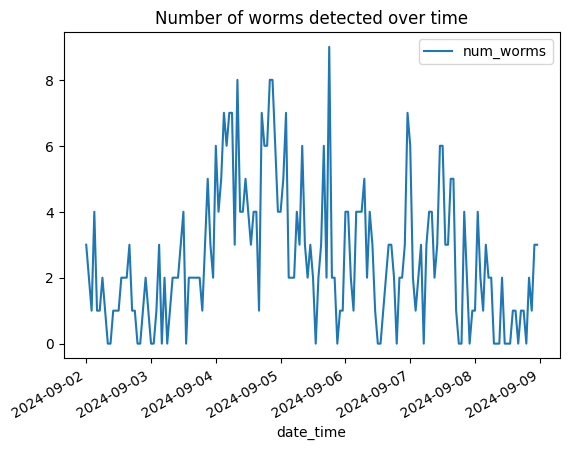

In [68]:
import matplotlib.pyplot as plt

worms_detected_count.plot(x='date_time', y='num_worms', kind='line', title='Number of worms detected over time')

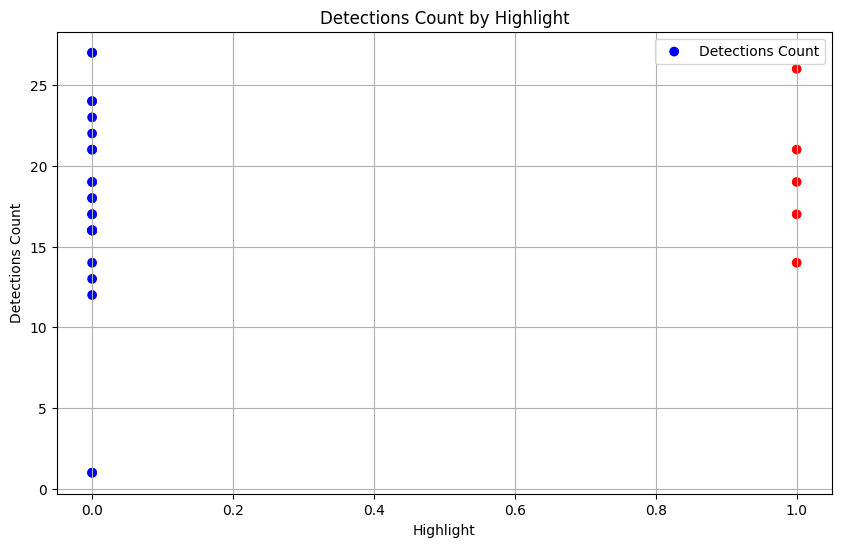

Correlation between worms and detections_count: 0.1276416811223834


In [ ]:
highlight_colors = merged_df['highlight'].map({0: 'blue', 1: 'red'})

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['highlight'], merged_df['detections_count'], c=highlight_colors, label='Detections Count')
plt.xlabel('Highlight')
plt.ylabel('Detections Count')
plt.title('Detections Count by Highlight')
plt.grid(True)
plt.legend()
plt.show()

# Calculate and display the correlation number
correlation = merged_df['highlight'].corr(merged_df['detections_count'])
print(f"Correlation between worms and detections_count: {correlation}")

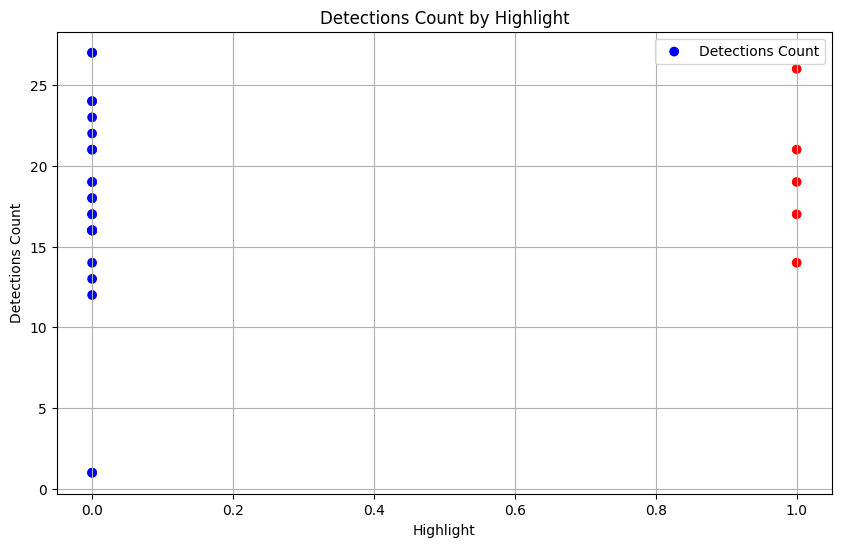

Correlation between worms and detections_count: 0.1276416811223834


In [ ]:
highlight_colors = merged_df['highlight'].map({0: 'blue', 1: 'red'})

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['highlight'], merged_df['detections_count'], c=highlight_colors, label='Detections Count')
plt.xlabel('Highlight')
plt.ylabel('Detections Count')
plt.title('Detections Count by Highlight')
plt.grid(True)
plt.legend()
plt.show()

# Calculate and display the correlation number
correlation = merged_df['highlight'].corr(merged_df['detections_count'])
print(f"Correlation between worms and detections_count: {correlation}")